In [ ]:
# =============================================================================
# MODEL TRAINING SCRIPT: Predicting delta_temp
# =============================================================================
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt


from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import joblib


from time import time

from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, GroupKFold
from sklearn.metrics import make_scorer, mean_squared_error, r2_score



In [ ]:
# -------------------------------------------------------------------------
# 0. CONFIGURATION
# -------------------------------------------------------------------------
DATASET_PATH = "euro_final_dataset_v2_filtered.csv"  # filtered dataset you just created
OUTPUT_DIR = "training_results"
RANDOM_SEED = 42

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Features (drop perc_water because it is redundant with land fractions)
FEATURES = [
    "latitude", "longitude", "elevation",
    "ndvi_local", "ndvi_global", "delta_ndvi",
    # land-cover fractions for the 9 km cell
    "perc_urban", "perc_suburban", "perc_forest",
    # wind & precipitation
    "era5_u10", "era5_v10", "wind_speed",
    "era5_precip", "rain_7day_avg",
    # seasonality
    "sin_day", "cos_day",
]

TARGET = "delta_temp"

In [ ]:
# -------------------------------------------------------------------------
# 1. LOAD DATA
# -------------------------------------------------------------------------
print(f"--- Loading dataset from '{DATASET_PATH}' ---")
df_all =pd.read_csv(DATASET_PATH, parse_dates=["time"])
print(f"Loaded {len(df_all):,} rows with {df_all.shape[1]} columns.")

missing_cols = [c for c in FEATURES + [TARGET, "STAID"] if c not in df_all.columns]
if missing_cols:
    raise ValueError(f"The following required columns are missing: {missing_cols}")

# -------------------------------------------------------------------------
# 2. BUILD FEATURE MATRIX AND TARGET VECTOR
# -------------------------------------------------------------------------
X =df_all[FEATURES].copy()
y=df_all[TARGET].values
stations = df_all["STAID"].values

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape : {y.shape}")

# -------------------------------------------------------------------------
# 3. TRAIN / VAL / TEST SPLIT BY STATION
# -------------------------------------------------------------------------
unique_stations = np.unique(stations)
rng=np.random.RandomState(RANDOM_SEED)
rng.shuffle(unique_stations)

n_stations =len(unique_stations)
n_train =int(0.70 * n_stations)
n_val=int(0.15 * n_stations)
train_stations =unique_stations[:n_train]
val_stations= unique_stations[n_train:n_train + n_val]
test_stations= unique_stations[n_train + n_val:]

def station_mask(sta_list):
    return np.isin(stations, sta_list)

train_mask =station_mask(train_stations)
val_mask=station_mask(val_stations)
test_mask  =station_mask(test_stations)

X_train, y_train = X[train_mask], y[train_mask]
X_val,y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

print("\n--- Station-based split ---")
print(f"Total stations : {n_stations}")
print(f"Train stations : {len(train_stations)}")
print(f"Val stations   : {len(val_stations)}")
print(f"Test stations  : {len(test_stations)}")

print(f"\nRows in train : {len(y_train):,}")
print(f"Rows in val   : {len(y_val):,}")
print(f"Rows in test  : {len(y_test):,}")

# -------------------------------------------------------------------------
# 4. DEFINE MODELS
# -------------------------------------------------------------------------
models = {}

models["LinearRegression"] = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", LinearRegression(n_jobs=-1)),
])

models["RandomForest"] =RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=RANDOM_SEED,
)

models["GradientBoosting"] =GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=RANDOM_SEED,
)

# -------------------------------------------------------------------------
# 5. TRAINING AND EVALUATION
# -------------------------------------------------------------------------
def evaluate(y_true, y_pred, name, split):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae=mean_absolute_error(y_true, y_pred)
    r2 =r2_score(y_true, y_pred)
    bias = float(np.mean(y_pred - y_true))
    print(f"[{name}-{split}]  RMSE={rmse:.3f}  MAE={mae:.3f}  R²={r2:.3f}  Bias={bias:.3f}")
    return rmse, mae, r2, bias

metrics_rows = []

for name, model in models.items():
    print("\n" + "="*80)
    print(f"Training model: {name}")
    print("=" * 80)

    model.fit(X_train, y_train)

    y_train_pred =model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred =model.predict(X_test)

    for split_name, yt, yp in [
        ("train", y_train, y_train_pred),
        ("val",   y_val,   y_val_pred),
        ("test",  y_test,  y_test_pred),
    ]:
        rmse, mae, r2, bias = evaluate(yt, yp, name, split_name)
        metrics_rows.append({
            "model": name,
            "split": split_name,
            "rmse": rmse,
            "mae": mae,
            "r2": r2,
            "bias": bias,
        })

    # ---------------------------------------------------------------------
    # 6. SIMPLE PREDICTION INTERVALS FOR RANDOM FOREST
    # ---------------------------------------------------------------------
    if name== "RandomForest":
        print("\nComputing simple 95% prediction intervals for RandomForest on TEST set...")
        all_tree_preds = np.stack([tree.predict(X_test) for tree in model.estimators_], axis=0)
        lower = np.percentile(all_tree_preds, 2.5, axis=0)
        upper = np.percentile(all_tree_preds, 97.5, axis=0)

        # Empirical coverage: fraction of true values inside [lower, upper]
        coverage = np.mean((y_test >= lower) & (y_test <= upper))
        interval_width = np.mean(upper - lower)

        print(f"[RandomForest-test]  95% interval coverage ≈ {coverage*100:.1f}%")
        print(f"[RandomForest -test]  mean interval width ≈ {interval_width:.3f} °C")

        metrics_rows.append({
            "model": name,
            "split": "test_interval",
            "rmse": np.nan,
            "mae":  np.nan,
            "r2":   np.nan,
            "bias": np.nan,
            "coverage_95": coverage,
            "mean_width_95": interval_width,
        })

# -------------------------------------------------------------------------
# 7. SAVE METRICS
# -------------------------------------------------------------------------
metrics_df=pd.DataFrame(metrics_rows)

if "coverage_95" not in metrics_df.columns:
    metrics_df["coverage_95"] = np.nan
if "mean_width_95" not in metrics_df.columns:
    metrics_df["mean_width_95"] = np.nan

metrics_path = os.path.join(OUTPUT_DIR, "model_metrics.csv")
metrics_df.to_csv(metrics_path, index=False)
print("\nAll metrics saved to:", metrics_path)

print("\nDone.")


--- Loading dataset from 'euro_final_dataset_v2_filtered.csv' ---
Loaded 3,033,739 rows with 22 columns.

Feature matrix shape: (3033739, 16)
Target vector shape : (3033739,)

--- Station-based split ---
Total stations : 1891
Train stations : 1323
Val stations   : 283
Test stations  : 285

Rows in train : 2,112,303
Rows in val   : 448,797
Rows in test  : 472,639

Training model: LinearRegression
[LinearRegression - train]  RMSE=2.513  MAE=1.830  R²=0.089  Bias=0.000
[LinearRegression - val]  RMSE=2.270  MAE=1.683  R²=0.126  Bias=-0.091
[LinearRegression - test]  RMSE=2.448  MAE=1.757  R²=0.018  Bias=-0.168

Training model: RandomForest
[RandomForest - train]  RMSE=0.806  MAE=0.568  R²=0.906  Bias=-0.001
[RandomForest - val]  RMSE=2.042  MAE=1.452  R²=0.293  Bias=-0.115
[RandomForest - test]  RMSE=2.208  MAE=1.435  R²=0.201  Bias=-0.151

Computing simple 95% prediction intervals for RandomForest on TEST set...


c:\Users\drugm\anaconda3\envs\genhack\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\drugm\anaconda3\envs\genhack\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\drugm\anaconda3\envs\genhack\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\drugm\anaconda3\envs\genhack\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\drugm\anaconda3\envs\genhack\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


[RandomForest - test]  95% interval coverage ≈ 80.9%
[RandomForest - test]  mean interval width ≈ 4.570 °C

Training model: GradientBoosting
[GradientBoosting - train]  RMSE=1.853  MAE=1.392  R²=0.505  Bias=-0.000
[GradientBoosting - val]  RMSE=1.957  MAE=1.464  R²=0.351  Bias=-0.055
[GradientBoosting - test]  RMSE=2.218  MAE=1.532  R²=0.194  Bias=-0.164

All metrics saved to: training_results\model_metrics.csv

Done.



RandomForest feature importances:
elevation        0.2262
latitude         0.1521
longitude        0.1042
cos_day          0.0647
perc_urban       0.0547
perc_forest      0.0472
era5_precip      0.0439
era5_v10         0.0399
delta_ndvi       0.0398
era5_u10         0.0389
wind_speed       0.0367
rain_7day_avg    0.0353
sin_day          0.0352
perc_suburban    0.0278
ndvi_global      0.0275
ndvi_local       0.0260


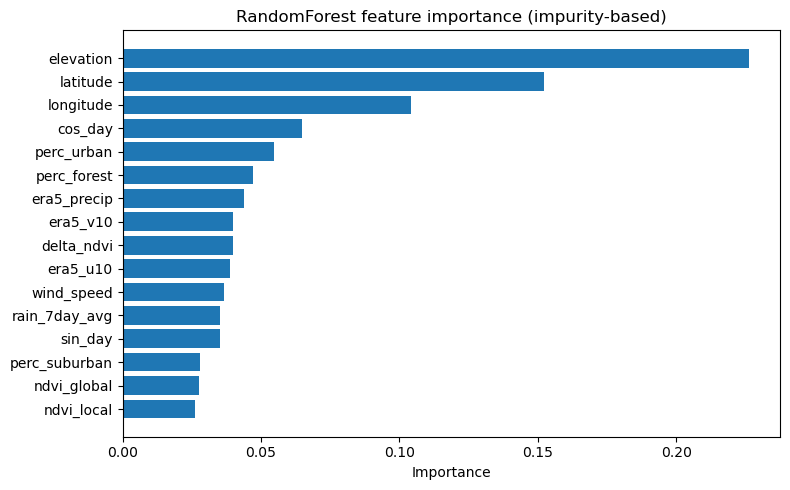

In [ ]:
rf=models["RandomForest"]

importances =rf.feature_importances_
idx = np.argsort(importances)[::-1]

print("\nRandomForest feature importances:")
for i in idx:
    print(f"{FEATURES[i]:15s}  {importances[i]:.4f}")

plt.figure(figsize=(8, 5))
plt.barh([FEATURES[i] for i in idx], importances[idx])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("RandomForest feature importance (impurity-based)")
plt.tight_layout()
plt.show()



Computing permutation feature importance on validation set...

Permutation importances (validation set):
      feature  perm_importance_mean  perm_importance_std
    elevation                0.7113               0.0040
     latitude                0.5190               0.0015
  perc_forest                0.3021               0.0024
    longitude                0.2473               0.0015
      cos_day                0.1585               0.0005
      sin_day                0.0548               0.0004
   wind_speed                0.0435               0.0003
  era5_precip                0.0431               0.0003
   ndvi_local                0.0410               0.0003
rain_7day_avg                0.0402               0.0003
     era5_u10                0.0367               0.0005
     era5_v10                0.0358               0.0001
  ndvi_global                0.0268               0.0004
   perc_urban                0.0230               0.0005
perc_suburban                0.0032    

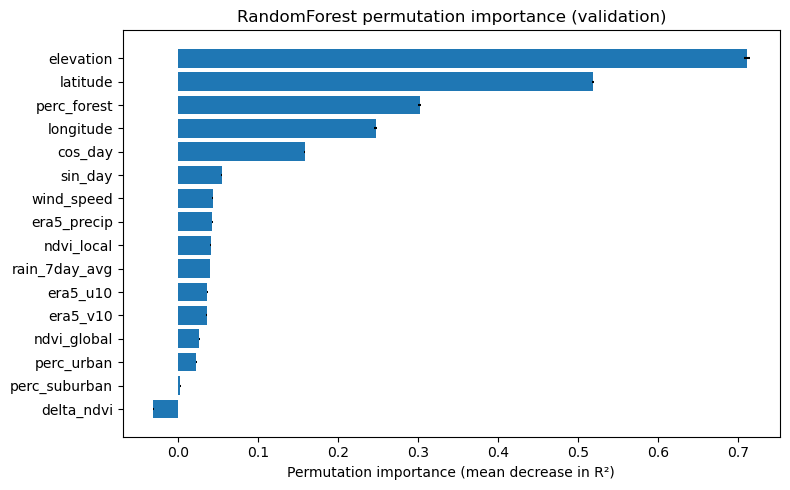


Generating partial dependence plots for: ['elevation', 'perc_urban', 'wind_speed', 'cos_day']


c:\Users\drugm\anaconda3\envs\genhack\lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 2 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


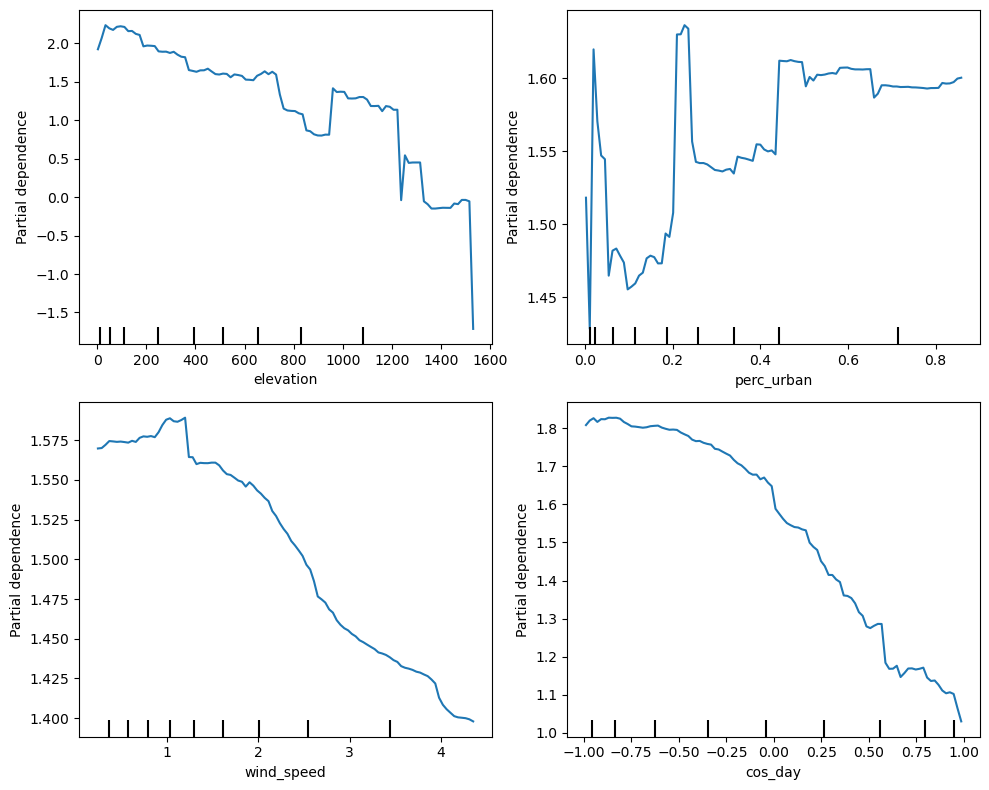


✅ Saved best RandomForest model to: training_results\best_model_random_forest.joblib


In [ ]:
# =============================================================================
# INTERPRETATION & SAVING: permutation importance + PDP + save best model
# =============================================================================


rf =models["RandomForest"]

# -------------------------------------------------------------------------
# 2) Permutation importance on the VALIDATION set
# -------------------------------------------------------------------------
print("\nComputing permutation feature importance on validation set...")
perm_result = permutation_importance(
    rf,
    X_val, 
    y_val,
    n_repeats=5,
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

perm_mean = perm_result.importances_mean
perm_std =perm_result.importances_std

perm_df = pd.DataFrame({
    "feature": FEATURES,
    "perm_importance_mean": perm_mean,
    "perm_importance_std": perm_std,
}).sort_values("perm_importance_mean", ascending=False)

print("\nPermutation importances (validation set):")
print(perm_df.to_string(index=False, float_format=lambda x: f"{x:0.4f}"))

plt.figure(figsize=(8, 5))
plt.barh(perm_df["feature"], perm_df["perm_importance_mean"],
         xerr=perm_df["perm_importance_std"])
plt.gca().invert_yaxis()
plt.xlabel("Permutation importance (mean decrease in R²)")
plt.title("RandomForest permutation importance (validation)")
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------
# 3) Partial Dependence Plots for key features
# -------------------------------------------------------------------------
features_for_pdp=["elevation", "perc_urban", "wind_speed", "cos_day"]

print("\nGenerating partial dependence plots for:", features_for_pdp)

fig, axes =plt.subplots(2, 2, figsize=(10, 8))
for i, feat in enumerate(features_for_pdp):
    r, c = divmod(i, 2)
    PartialDependenceDisplay.from_estimator(
        rf,
        X_val,
        [feat],
        kind="average",
        ax=axes[r, c],
    )
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------
# 4) Save the best model (RandomForest) to disk
# -------------------------------------------------------------------------
best_model_path=os.path.join(OUTPUT_DIR, "best_model_random_forest.joblib")
joblib.dump(rf, best_model_path)
print(f"\n✅ Saved best RandomForest model to: {best_model_path}")


In [ ]:
# =============================================================================
# APPLY MODEL ON TEST SET: compare ERA5 vs corrected vs station
# =============================================================================


rf=models["RandomForest"]

y_test_pred =rf.predict(X_test)

test_df =df_all.iloc[np.where(test_mask)[0]].copy()
assert len(test_df) ==len(y_test_pred)

test_df["delta_obs"] = y_test   
test_df["delta_pred"] = y_test_pred   
test_df["TX_corr"] = test_df["era5_temp_max"] + test_df["delta_pred"]


def summarize_errors(true, pred, label):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae  = mean_absolute_error(true, pred)
    bias = float(np.mean(pred - true))
    print(f"[{label}]  RMSE={rmse:.3f}  MAE={mae:.3f}  Bias={bias:.3f}")
    return rmse, mae, bias

print("\n=== Test set error before and after correction ===")
rmse_raw,  mae_raw,  bias_raw  = summarize_errors(
    test_df["TX"], test_df["era5_temp_max"], "ERA5_raw"
)
rmse_corr, mae_corr, bias_corr = summarize_errors(
    test_df["TX"], test_df["TX_corr"], "ERA5_corrected_RF"
)

station_bias = (
    test_df.groupby("STAID")[["delta_obs", "delta_pred"]]
    .mean()
    .rename(columns={"delta_obs": "mean_bias_obs", "delta_pred": "mean_bias_pred"})
)

print("\nPer-station mean bias (first 10 rows):")
print(station_bias.head(10).round(3))

station_bias.to_csv(os.path.join(OUTPUT_DIR, "station_bias_test_RF.csv"))
test_df.to_csv(os.path.join(OUTPUT_DIR, "test_predictions_RF.csv"), index=False)

print("\nSaved detailed test predictions and per-station bias to disk.")


# overnight hy tuning

In [ ]:
# -------------------------------------------------------------------------
# OPTIONAL: add non-linear (log) versions of skewed features
# -------------------------------------------------------------------------

for col in ["era5_precip", "rain_7day_avg", "wind_speed"]:
    df_all[col] = df_all[col].clip(lower=0)

df_all["era5_precip_log1p"] = np.log1p(df_all["era5_precip"])
df_all["rain_7day_avg_log1p"]= np.log1p(df_all["rain_7day_avg"])
df_all["wind_speed_log1p"]  = np.log1p(df_all["wind_speed"])

FEATURES = [
    "latitude", "longitude", "elevation",
    "ndvi_local", "ndvi_global",
    "perc_urban", "perc_suburban", "perc_forest",
    "era5_u10", "era5_v10", "wind_speed", "wind_speed_log1p",
    "era5_precip", "era5_precip_log1p",
    "rain_7day_avg", "rain_7day_avg_log1p",
    "sin_day", "cos_day",
]

X = df_all[FEATURES].copy()
y = df_all[TARGET].values
stations = df_all["STAID"].values


In [ ]:
# -------------------------------------------------------------------------
# REBUILD STATION-BASED SPLIT WITH NEW FEATURE MATRIX X
# -------------------------------------------------------------------------
RANDOM_SEED = 42

stations = df_all["STAID"].values

unique_stations = np.unique(stations)
rng = np.random.RandomState(RANDOM_SEED)
rng.shuffle(unique_stations)

n_stations = len(unique_stations)
n_train=int(0.70 * n_stations)
n_val = int(0.15 * n_stations)

train_stations = unique_stations[:n_train]
val_stations =unique_stations[n_train:n_train + n_val]
test_stations=unique_stations[n_train + n_val:]

def station_mask(sta_list):
    return np.isin(stations, sta_list)

train_mask = station_mask(train_stations)
val_mask =station_mask(val_stations)
test_mask= station_mask(test_stations)

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val= X[val_mask], y[val_mask]
X_test,y_test= X[test_mask],  y[test_mask]

print("\nRebuilt splits with log features:")
print(f"Rows in train : {len(y_train):,}")
print(f"Rows in val : {len(y_val):,}")
print(f"Rows in test  : {len(y_test):,}")



Rebuilt splits with log features:
Rows in train : 2,112,303
Rows in val   : 448,797
Rows in test  : 472,639


In [ ]:
# =============================================================================
# OVERNIGHT HYPERPARAMETER SEARCH (RF + HistGBM) WITH STATION-GROUPED CV
# =============================================================================


print("\n================  OVERNIGHT HYPERPARAMETER SEARCH  ================")

# -------------------------------------------------------------------------
# 0. Prepare development set: train + val, grouped by station
# -------------------------------------------------------------------------
dev_mask = train_mask | val_mask
X_dev = X[dev_mask]
y_dev = y[dev_mask]
groups_dev = stations[dev_mask]

print(f"Development set size (train+val): {len(y_dev):,} rows")

# GroupKFold over stations: 3 folds (each fold holds out a subset of stations)
gkf = GroupKFold(n_splits=3)

def rmse_scorer(y_true, y_pred):
    return -np.sqrt(mean_squared_error(y_true, y_pred))

scoring = {
    "neg_rmse": make_scorer(rmse_scorer),
    "r2": r2_score,
}

# -------------------------------------------------------------------------
# 1. RandomForest hyperparameter search
# -------------------------------------------------------------------------
rf_base = RandomForestRegressor(
    n_estimators=400,
    n_jobs=-1,
    random_state=RANDOM_SEED,
)

rf_param_dist = {
    "n_estimators":   [200, 300, 400, 500],
    "max_depth":      [None, 18, 24, 30, 40],
    "min_samples_leaf": [2, 5, 7, 10],
    "max_features":   ["sqrt", 0.5, 0.7],
}

rf_search = RandomizedSearchCV(
    rf_base,
    param_distributions=rf_param_dist,
    n_iter=16,                 # 16 configs; each uses full dev set
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    cv=gkf.split(X_dev, y_dev, groups=groups_dev),
    verbose=2,
    random_state=RANDOM_SEED,
)

print("\n--- Starting RandomForest search (this can take several hours) ---")
t0 = time()
rf_search.fit(X_dev, y_dev)
t1 = time()
print(f"RandomForest search finished in {(t1 - t0)/3600:.2f} hours")

print("\nBest RF params:")
print(rf_search.best_params_)
print(f"Best RF CV RMSE: {-rf_search.best_score_:.3f} °C")

best_rf = rf_search.best_estimator_

# -------------------------------------------------------------------------
# 2. HistGradientBoosting hyperparameter search
# -------------------------------------------------------------------------
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401

hgb_base = HistGradientBoostingRegressor(
    loss="squared_error",
    learning_rate=0.05,
    max_bins=255,
    random_state=RANDOM_SEED,
)

hgb_param_dist = {
    "max_depth":     [3, 5, 7, 10, 15, None],
    "max_leaf_nodes":   [31, 63, 127],
    "min_samples_leaf": [20, 50, 100],
    "l2_regularization": [0.0, 0.1, 0.5, 1.0],
    "learning_rate": [0.03, 0.05, 0.08],
    "max_iter":      [200, 400, 500, 600],
}

hgb_search = RandomizedSearchCV(
    hgb_base,
    param_distributions=hgb_param_dist,
    n_iter=18,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    cv=gkf.split(X_dev, y_dev, groups=groups_dev),
    verbose=2,
    random_state=RANDOM_SEED,
)

print("\n--- Starting HistGradientBoosting search ---")
t0 = time()
hgb_search.fit(X_dev, y_dev)
t1 = time()
print(f"HistGBM search finished in {(t1 - t0)/3600:.2f} hours")

print("\nBest HistGBM params:")
print(hgb_search.best_params_)
print(f"Best HistGBM CV RMSE: {-hgb_search.best_score_:.3f} °C")

best_hgb=hgb_search.best_estimator_

# -------------------------------------------------------------------------
# 3. Collect and save all CV results
# -------------------------------------------------------------------------
def collect_results(search, model_name):
    df = pd.DataFrame(search.cv_results_)
    cols = [
        "mean_test_score", "std_test_score",
        "param_n_estimators", "param_max_depth",
        "param_min_samples_leaf", "param_max_features",
        "param_max_leaf_nodes", "param_learning_rate",
        "param_min_samples_leaf", "param_l2_regularization",
        "param_max_iter",
    ]
    existing_cols = [c for c in cols if c in df.columns]
    df = df[existing_cols + ["rank_test_score"]]
    df.insert(0, "model_name", model_name)
    return df

rf_results  = collect_results(rf_search,  "RandomForest")
hgb_results = collect_results(hgb_search, "HistGradientBoosting")

all_results = pd.concat([rf_results, hgb_results], ignore_index=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
hp_path = os.path.join(OUTPUT_DIR, "hyperparam_results.csv")
all_results.to_csv(hp_path, index=False)
print("\nSaved hyperparameter search results to:", hp_path)

# -------------------------------------------------------------------------
# 4. Final evaluation on HELD-OUT TEST SET
# -------------------------------------------------------------------------

def eval_on_test(model, name):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    bias = float(np.mean(y_pred - y_test))
    print(f"[{name} - test] RMSE={rmse:.3f}  MAE={mae:.3f}  R²={r2:.3f}  Bias={bias:.3f}")
    return rmse, mae, r2, bias

print("\n=== Final evaluation of tuned models on TEST set ===")
rf_rmse, rf_mae, rf_r2, rf_bias   = eval_on_test(best_rf,  "RandomForest_tuned")
hgb_rmse, hgb_mae, hgb_r2, hgb_bias = eval_on_test(best_hgb, "HistGBM_tuned")

summary = pd.DataFrame([
    {"model": "RandomForest_tuned",  "rmse": rf_rmse,  "mae": rf_mae,  "r2": rf_r2,  "bias": rf_bias},
    {"model": "HistGBM_tuned",      "rmse": hgb_rmse, "mae": hgb_mae, "r2": hgb_r2, "bias": hgb_bias},
])
summary_path = os.path.join(OUTPUT_DIR, "tuned_models_test_summary.csv")
summary.to_csv(summary_path, index=False)
print("Saved tuned model test summary to:", summary_path)

# -------------------------------------------------------------------------
# 5. Save tuned models
# -------------------------------------------------------------------------
rf_model_path  = os.path.join(OUTPUT_DIR, "best_random_forest_tuned.joblib")
hgb_model_path = os.path.join(OUTPUT_DIR, "best_histgbm_tuned.joblib")
joblib.dump(best_rf,  rf_model_path)
joblib.dump(best_hgb, hgb_model_path)
print("\nSaved tuned models to:")
print("  ", rf_model_path)
print("  ", hgb_model_path)

print("\n================  HYPERPARAM SEARCH COMPLETE  ================")



================  OVERNIGHT HYPERPARAMETER SEARCH  ================
Development set size (train+val): 2,561,100 rows

--- Starting RandomForest search (this can take several hours) ---
Fitting 3 folds for each of 16 candidates, totalling 48 fits


c:\Users\drugm\anaconda3\envs\genhack\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
9 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\drugm\anaconda3\envs\genhack\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\drugm\anaconda3\envs\genhack\lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "c:\Users\drugm\anaconda3\envs\genhack\lib\site-packages\sklearn\base.py", line 471, in _validate_params
    validate_parameter_constraints(
 

RandomForest search finished in 2.01 hours

Best RF params:
{'n_estimators': 200, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 30}
Best RF CV RMSE: 1.843 °C

--- Starting HistGradientBoosting search ---
Fitting 3 folds for each of 18 candidates, totalling 54 fits


c:\Users\drugm\anaconda3\envs\genhack\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:18: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


HistGBM search finished in 0.15 hours

Best HistGBM params:
{'min_samples_leaf': 100, 'max_leaf_nodes': 31, 'max_iter': 600, 'max_depth': 15, 'learning_rate': 0.05, 'l2_regularization': 0.5}
Best HistGBM CV RMSE: 1.904 °C


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [7]:
# -------------------------------------------------------------------------
# 3. Collect and save all CV results (fixed)
# -------------------------------------------------------------------------
def collect_results(search, model_name):
    df = pd.DataFrame(search.cv_results_).copy()
    df.insert(0, "model_name", model_name)
    return df

rf_results  = collect_results(rf_search,  "RandomForest")
hgb_results = collect_results(hgb_search, "HistGradientBoosting")

all_results = pd.concat([rf_results, hgb_results], ignore_index=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
hp_path = os.path.join(OUTPUT_DIR, "hyperparam_results.csv")
all_results.to_csv(hp_path, index=False)
print("\nSaved hyperparameter search results to:", hp_path)

# -------------------------------------------------------------------------
# 4. Final evaluation on HELD-OUT TEST SET
# -------------------------------------------------------------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_on_test(model, name):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    bias = float(np.mean(y_pred - y_test))
    print(f"[{name} - test] RMSE={rmse:.3f}  MAE={mae:.3f}  R²={r2:.3f}  Bias={bias:.3f}")
    return rmse, mae, r2, bias

print("\n=== Final evaluation of tuned models on TEST set ===")
rf_rmse, rf_mae, rf_r2, rf_bias   = eval_on_test(best_rf,  "RandomForest_tuned")
hgb_rmse, hgb_mae, hgb_r2, hgb_bias = eval_on_test(best_hgb, "HistGBM_tuned")

summary = pd.DataFrame([
    {"model": "RandomForest_tuned",  "rmse": rf_rmse,  "mae": rf_mae,  "r2": rf_r2,  "bias": rf_bias},
    {"model": "HistGBM_tuned",      "rmse": hgb_rmse, "mae": hgb_mae, "r2": hgb_r2, "bias": hgb_bias},
])
summary_path = os.path.join(OUTPUT_DIR, "tuned_models_test_summary.csv")
summary.to_csv(summary_path, index=False)
print("Saved tuned model test summary to:", summary_path)

# -------------------------------------------------------------------------
# 5. Save tuned models
# -------------------------------------------------------------------------
rf_model_path  = os.path.join(OUTPUT_DIR, "best_random_forest_tuned.joblib")
hgb_model_path = os.path.join(OUTPUT_DIR, "best_histgbm_tuned.joblib")
joblib.dump(best_rf,  rf_model_path)
joblib.dump(best_hgb, hgb_model_path)
print("\nSaved tuned models to:")
print("  ", rf_model_path)
print("  ", hgb_model_path)

print("\n================  HYPERPARAM SEARCH COMPLETE  ================")



Saved hyperparameter search results to: training_results\hyperparam_results.csv

=== Final evaluation of tuned models on TEST set ===
[RandomForest_tuned - test] RMSE=1.938  MAE=1.256  R²=0.384  Bias=-0.117
[HistGBM_tuned - test] RMSE=2.062  MAE=1.387  R²=0.303  Bias=-0.090
Saved tuned model test summary to: training_results\tuned_models_test_summary.csv

Saved tuned models to:
   training_results\best_random_forest_tuned.joblib
   training_results\best_histgbm_tuned.joblib

================  HYPERPARAM SEARCH COMPLETE  ================
